In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# === Load and Normalize Dataset ===
data = pd.read_csv("D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv")
X = data.values

# Optional: check shape
print("Original data shape:", data.shape)

Original data shape: (500, 3736)


In [3]:
# === Standar Scaler ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# === Split Dataset ===
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [5]:
# === Apply PCA to Reduce Noise ===
pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [6]:
# === Convert to Tensors ===
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

In [7]:
# Create DataLoader for training and testing 
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

In [8]:
print("Training tensor shape:", X_train_tensor.shape)
print("Test tensor shape:", X_test_tensor.shape)

Training tensor shape: torch.Size([400, 19])
Test tensor shape: torch.Size([100, 19])


In [9]:
# === Define Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# === Training Setup ===
input_dim = X_train_pca.shape[1]
encoding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Epoch [1000/10000], Train Loss: 0.0257, Val Loss: 0.1191
Epoch [2000/10000], Train Loss: 0.0122, Val Loss: 0.1075
Epoch [3000/10000], Train Loss: 0.0052, Val Loss: 0.1011
Epoch [4000/10000], Train Loss: 0.0034, Val Loss: 0.0947
Epoch [5000/10000], Train Loss: 0.0112, Val Loss: 0.1062
Epoch [6000/10000], Train Loss: 0.0059, Val Loss: 0.0924
Epoch [7000/10000], Train Loss: 0.0146, Val Loss: 0.1042
Epoch [8000/10000], Train Loss: 0.0023, Val Loss: 0.0888
Epoch [9000/10000], Train Loss: 0.0514, Val Loss: 0.1212
Epoch [10000/10000], Train Loss: 0.0171, Val Loss: 0.0974


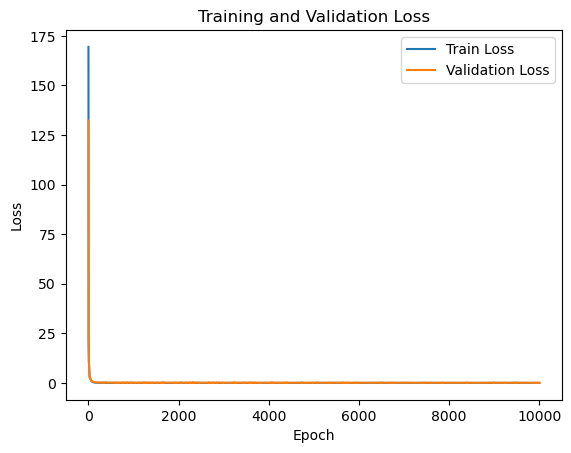

In [11]:
# === Training Loop ===
num_epochs = 10000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch.to(device)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.to(device)
            _, outputs = model(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_losses.append(val_loss / len(test_loader))

    # === Print Progress ===
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# === Plot Loss Curves ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# === Generate Synthetic Data ===
model.eval()
n_samples = 500
latent_dim = encoding_dim

latent_samples = torch.randn(n_samples, latent_dim).to(device)
with torch.no_grad():
    synthetic_decoded = model.decoder(latent_samples)

synthetic_decoded_np = synthetic_decoded.cpu().numpy()
synthetic_original_space = pca.inverse_transform(synthetic_decoded_np)
synthetic_data = scaler.inverse_transform(synthetic_original_space)

print("Synthetic data shape:", synthetic_data.shape)

Synthetic data shape: (500, 3736)


In [13]:
# Reload real data to get column names
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Create a DataFrame for the synthetic data with correct columns
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# Save to CSV
synthetic_df.to_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_DT.csv', index=False)

print("✅ 500 synthetic samples generated and saved successfully!")

✅ 500 synthetic samples generated and saved successfully!


In [14]:
print("X_train shape:", X_train.shape)
print("synthetic_data shape:", synthetic_data.shape)
print("Total elements in X_train:", X_train.size)
print("Total elements in synthetic_data:", synthetic_data.size)

X_train shape: (400, 3736)
synthetic_data shape: (500, 3736)
Total elements in X_train: 1494400
Total elements in synthetic_data: 1868000


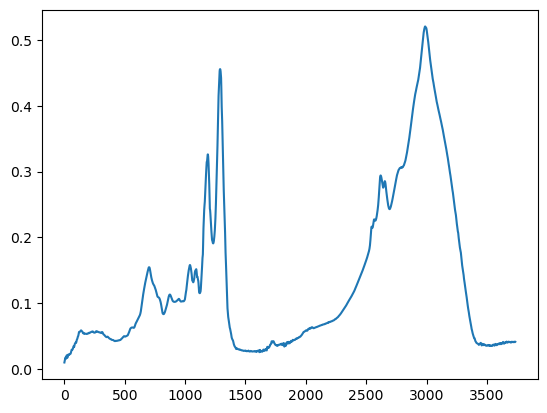

In [15]:
 plt.plot(synthetic_data [50,:])

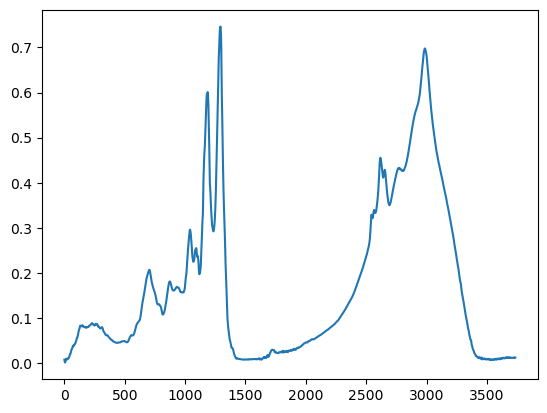

In [16]:
plt.plot(X[50,:])

In [17]:
np.shape(synthetic_data)

(500, 3736)

In [18]:
Y = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_DT.csv')  

In [19]:
print (Y)

     Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
0         0.009267       0.009196       0.009289       0.009513   
1         0.013546       0.013587       0.013308       0.012944   
2         0.016824       0.015947       0.014488       0.012983   
3         0.015184       0.014140       0.012975       0.011994   
4         0.015476       0.015681       0.015217       0.014594   
..             ...            ...            ...            ...   
495       0.012059       0.010155       0.009216       0.009034   
496       0.017048       0.016105       0.014986       0.013887   
497       0.012304       0.012027       0.011913       0.012006   
498       0.016179       0.015614       0.014656       0.013654   
499       0.009032       0.008367       0.008217       0.008440   

     Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
0         0.009903       0.010569       0.011641       0.013169   
1         0.012657       0.012571       0.012775       0.0132

In [20]:
data_fake = Y

In [21]:
data_fake.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.009267,0.009196,0.009289,0.009513,0.009903,0.010569,0.011641,0.013169,0.015002,0.016775,...,0.041480,0.041359,0.041270,0.041202,0.041112,0.040979,0.040826,0.040711,0.040677,0.041006
1,0.013546,0.013587,0.013308,0.012944,0.012657,0.012571,0.012775,0.013297,0.014061,0.014896,...,0.041609,0.041557,0.041503,0.041425,0.041295,0.041111,0.040921,0.040794,0.040775,0.041175
2,0.016824,0.015947,0.014488,0.012983,0.011867,0.011438,0.011805,0.012844,0.014217,0.015506,...,0.041353,0.041384,0.041436,0.041465,0.041425,0.041314,0.041178,0.041086,0.041082,0.041511
3,0.015184,0.014140,0.012975,0.011994,0.011393,0.011331,0.011896,0.013030,0.014488,0.015905,...,0.041864,0.041846,0.041844,0.041815,0.041722,0.041568,0.041404,0.041300,0.041300,0.041802
4,0.015476,0.015681,0.015217,0.014594,0.014039,0.013564,0.013121,0.012727,0.012504,0.012615,...,0.039293,0.039291,0.039288,0.039261,0.039183,0.039056,0.038920,0.038828,0.038817,0.039251


In [22]:
pip install --upgrade table_evaluator

Note: you may need to restart the kernel to use updated packages.


In [23]:
data_fake.shape

(500, 3736)

In [24]:
from table_evaluator import load_data, TableEvaluator

In [25]:
real, fake = load_data('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv', 'C:\\Users\\Ahmed\\Final\\synthetic_data_AE_DT.csv')

In [26]:
real.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.002788,0.002679,0.002590,0.002397,0.002003,0.001440,0.001000,0.001180,0.002424,0.004826,...,0.055228,0.055092,0.054975,0.054888,0.054804,0.054691,0.054528,0.054321,0.054095,0.055661
1,0.011223,0.008644,0.005475,0.002793,0.001204,0.001000,0.002254,0.004759,0.007979,0.011209,...,0.061770,0.061952,0.062080,0.062084,0.061915,0.061576,0.061120,0.060638,0.060233,0.061807
2,0.008241,0.005308,0.002601,0.001042,0.001000,0.002507,0.005380,0.009190,0.013286,0.016967,...,0.074086,0.074106,0.074020,0.073812,0.073489,0.073087,0.072667,0.072293,0.072012,0.073635
3,0.004690,0.002150,0.001000,0.001314,0.002725,0.004786,0.006996,0.008779,0.009587,0.009128,...,0.048002,0.047823,0.047553,0.047284,0.047106,0.047079,0.047209,0.047450,0.047716,0.048322
4,-0.000024,0.001000,0.001965,0.002710,0.003198,0.003527,0.003874,0.004343,0.004843,0.005093,...,0.028844,0.028710,0.028535,0.028377,0.028270,0.028223,0.028226,0.028253,0.028278,0.028715


In [27]:
fake.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.009267,0.009196,0.009289,0.009513,0.009903,0.010569,0.011641,0.013169,0.015002,0.016775,...,0.041480,0.041359,0.041270,0.041202,0.041112,0.040979,0.040826,0.040711,0.040677,0.041006
1,0.013546,0.013587,0.013308,0.012944,0.012657,0.012571,0.012775,0.013297,0.014061,0.014896,...,0.041609,0.041557,0.041503,0.041425,0.041295,0.041111,0.040921,0.040794,0.040775,0.041175
2,0.016824,0.015947,0.014488,0.012983,0.011867,0.011438,0.011805,0.012844,0.014217,0.015506,...,0.041353,0.041384,0.041436,0.041465,0.041425,0.041314,0.041178,0.041086,0.041082,0.041511
3,0.015184,0.014140,0.012975,0.011994,0.011393,0.011331,0.011896,0.013030,0.014488,0.015905,...,0.041864,0.041846,0.041844,0.041815,0.041722,0.041568,0.041404,0.041300,0.041300,0.041802
4,0.015476,0.015681,0.015217,0.014594,0.014039,0.013564,0.013121,0.012727,0.012504,0.012615,...,0.039293,0.039291,0.039288,0.039261,0.039183,0.039056,0.038920,0.038828,0.038817,0.039251


In [28]:
# Apply the classifier

# === Suppress warnings ===
warnings.simplefilter(action='ignore', category=FutureWarning)

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)

# === Shuffle the data ===
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_12672\1834002293.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fake['label'] = 1  # Synthetic


In [29]:
# === Train Decision Tree Classifier ===
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

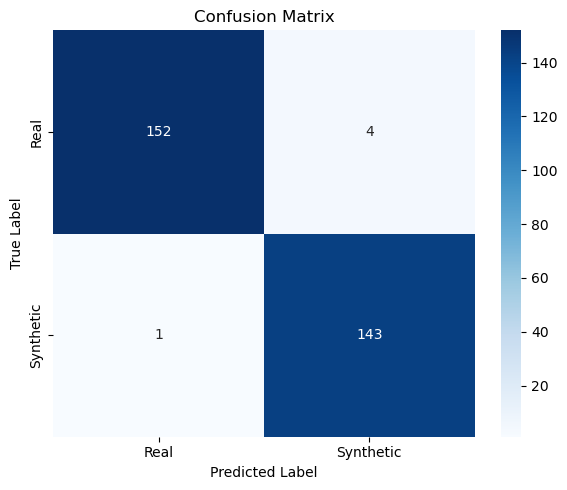

Accuracy:  0.98
Precision: 0.97
Recall:    0.99
F1 Score:  0.98


In [30]:
# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()

# === Print Metrics ===
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

In [31]:
# 10-fold cross validation 

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Set up classifier and cross-validation ===
clf = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Cross-validated predictions ===
y_pred = cross_val_predict(clf, X, y, cv=cv)

Accuracy:  0.9900
Precision: 0.9900
Recall:    0.9900
F1 Score:  0.9900


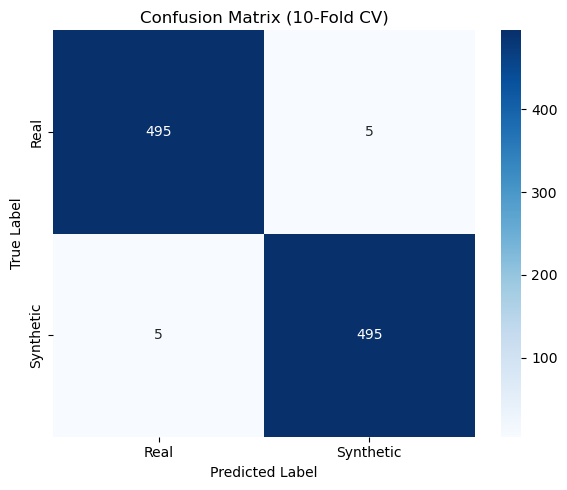

In [32]:
# === Compute metrics ===
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# === Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (10-Fold CV)')
plt.tight_layout()
plt.show()

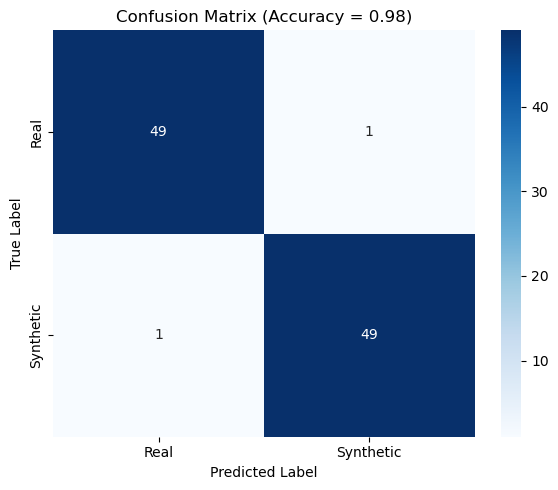

Accuracy:  0.9800
Precision: 0.9800
Recall:    0.9800
F1 Score:  0.9800


In [33]:
# Mixed the Real and the fake data, took 50% of each dataset, and combined them. 

# === Load datasets ===
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_DT.csv')

# === Take 50% from each dataset ===
real_sample = real_data.sample(frac=0.5, random_state=42)
fake_sample = fake_data.sample(frac=0.5, random_state=42)

# === Label the datasets ===
real_sample['label'] = 0  # Real
fake_sample['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real_sample, fake_sample], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# === Train Decision Tree Classifier ===
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")